<a href="https://colab.research.google.com/github/Shruti-Bibra/Transformers-in-VQA-A-Comparative-Study-of-Multimodal-and-Single-Modality-Fusion-Approaches/blob/main/VQAusingRoBERTa%26BieT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [1]:
!pip install transformers nltk numpy datasets==2.16.0
!pip install kaggle

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.


In [2]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    RobertaTokenizer, BeitImageProcessor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using RobertaModel)
    RobertaModel, AutoConfig, BeitModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging,

    EarlyStoppingCallback
)

import warnings
warnings.filterwarnings('ignore')
import safetensors
import nltk
nltk.download('wordnet')
import nltk
import subprocess
import random

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score
import kagglehub

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet to /kaggle/working/...


In [3]:
os.environ['HF_HOME'] = os.path.join(".", "cache")

set_caching_enabled(True)
logging.set_verbosity_error()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA L4


Loading the DAQUAR data

In [5]:


path = kagglehub.dataset_download("tezansahu/processed-daquar-dataset")

print("Path to dataset files:", path)

100%|██████████| 411M/411M [00:04<00:00, 86.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tezansahu/processed-daquar-dataset/versions/3


Preprocessing DATA

In [6]:
# load dataset from CSV files for training and testing
dataset = load_dataset(
    "csv",
    data_files={
        "train": "/root/.cache/kagglehub/datasets/tezansahu/processed-daquar-dataset/versions/3/data_train.csv",
        "test": "/root/.cache/kagglehub/datasets/tezansahu/processed-daquar-dataset/versions/3/data_eval.csv"
    }
)

# read answer space from file and split into an array by line
with open("/root/.cache/kagglehub/datasets/tezansahu/processed-daquar-dataset/versions/3/answer_space.txt") as f:
    answer_space = f.read().splitlines()

# label each item in the dataset with their respective answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6795 [00:00<?, ? examples/s]

Map:   0%|          | 0/5673 [00:00<?, ? examples/s]

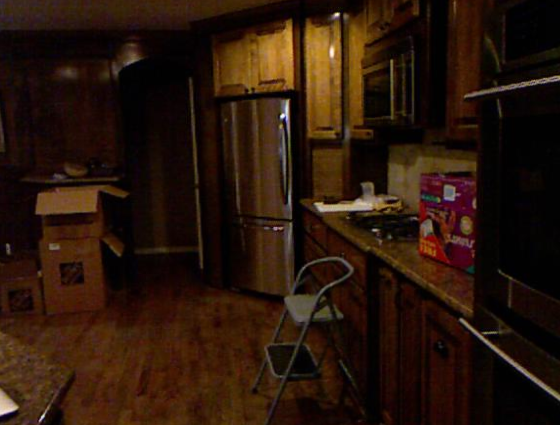

'dishwasher'

In [7]:
import IPython.display as display

def show_example(train=True, idx=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    image_path =  "/root/.cache/kagglehub/datasets/tezansahu/processed-daquar-dataset/versions/3/images/"+ f"{data[idx]['image_id']}.png"
    image = Image.open(image_path)
    display.display(image)

    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")

    return answer
show_example()

Roberta and BEIT

In [8]:
@dataclass
class MultimodalCollator:
    tokenizer: RobertaTokenizer
    preprocessor: BeitImageProcessor

    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }


    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:

        processed_images = self.preprocessor(
            images=[
                Image.open(os.path.join("/root/.cache/kagglehub/datasets/tezansahu/processed-daquar-dataset/versions/3/images/", f"{image_id}.png")).convert('RGB')
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }


    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:

        question_batch = raw_batch_dict['question'] if isinstance(raw_batch_dict, dict) else [i['question'] for i in raw_batch_dict]
        image_id_batch = raw_batch_dict['image_id'] if isinstance(raw_batch_dict, dict) else [i['image_id'] for i in raw_batch_dict]
        label_batch = raw_batch_dict['label'] if isinstance(raw_batch_dict, dict) else [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(question_batch),
            **self.preprocess_images(image_id_batch),
            'labels': torch.tensor(label_batch, dtype=torch.int64),
        }

Question:	 what is the object close to the wall right of the counter
Answer:		 dishwasher (Label: 166)


In [9]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = 'roberta-base',
        pretrained_image_name: str = 'microsoft/beit-base-patch16-224-pt22k'
    ):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        # Text and image encoders

        self.text_encoder = RobertaModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = BeitModel.from_pretrained(self.pretrained_image_name)

        # Fusion module
        self.fusion = nn.Sequential(
            nn.LayerNorm(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size),
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(intermediate_dim, self.num_labels)
        )

        self.criterion = nn.CrossEntropyLoss()

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):

        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )

        logits = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )

        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out


In [10]:
def create_multimodal_vqa_collator_and_model(text_encoder='roberta-base', image_encoder='microsoft/beit-base-patch16-224-pt22k'):

    # Initialize tokenizer and feature extractor
    tokenizer = RobertaTokenizer.from_pretrained(text_encoder)
    preprocessor = BeitImageProcessor.from_pretrained(image_encoder)

    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder,
        pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model

In [11]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """
    def get_semantic_field(word):

        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):

        weight = 1.0
        return word, weight

    global_weight = 1.0

    # Get stem words and weights
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # Check if words are the same
    if a == b:
        return 1.0 * global_weight

    if a == "" or b == "":
        return 0

    # Get semantic fields and weights
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    # Check for empty semantic fields
    if interp_a == [] or interp_b == []:
        return 0

    # Find the most optimistic interpretation
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # Use semantic fields and downweight unless the score is high (indicating synonyms)
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score

def batch_wup_measure(labels, preds):

    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [12]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['can', 'broom', 'cordless_phone', 'pool_ball', 'dog_toy']
['cat_cage', 'display_case', 'stove_burner', 'air_vent', 'toilet_brush']
Predictions vs Labels:  0.014117647058823532
Labels vs Labels:  1.0


Training the Model

In [13]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:

    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

    return metrics

In [17]:
# Define training arguments for the model

args = TrainingArguments(
    output_dir="/kaggle/working/checkpoint/",            # Output directory for checkpoints and logs=
    seed=12345,                         # Seed for reproducibility
    evaluation_strategy="steps",        # Evaluation strategy: "steps" or "epoch"
    eval_steps=100,                     # Evaluate every 100 steps
    logging_strategy="steps",           # Logging strategy: "steps" or "epoch"
    logging_steps=100,                  # Log every 100 steps
    save_strategy="steps",              # Saving strategy: "steps" or "epoch"
    save_steps=100,                     # Save every 100 steps
#     learning_rate=1.5e-6,
    save_total_limit=2,                 # Save only the last 3 checkpoints at any given time during training
    metric_for_best_model='wups',       # Metric used for determining the best model
    per_device_train_batch_size=32,     # Batch size per GPU for training
    per_device_eval_batch_size=32,      # Batch size per GPU for evaluation
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    num_train_epochs=20,                 # Number of training epochs
    weight_decay=1e-4,
    gradient_accumulation_steps=2,
#     lr_scheduler_type = "cosine",
    optim="adamw_torch",
    fp16=True,                          # Enable mixed precision training (float16)
    dataloader_num_workers=8,           # Number of workers for data loading
    load_best_model_at_end=True,        # Whether to load the best model at the end of training
)

In [18]:
def create_and_train_model(dataset, args, text_model='roberta-base', image_model='microsoft/beit-base-patch16-224-pt22k', multimodal_model='roberta_beit'):

    # Create Multimodal Collator and Model
    collator, model = create_multimodal_vqa_collator_and_model(text_model, image_model)


    # Initialize lists to store loss values
    train_losses = []
    val_losses = []


    multi_trainer = Trainer(
        model,
        args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics,
#         callbacks = [early_stop]
    )

    # Train and evaluate for metrics
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    log_history = multi_trainer.state.log_history


    for logs in log_history:
        if 'loss' in logs:  # Check if 'loss' key exists in the log dictionary
            train_losses.append(logs['loss'])

    # Assuming 'eval_loss' is logged during evaluation:
    for logs in log_history:
        if 'eval_loss' in logs:
            val_losses.append(logs['eval_loss'])

    return collator, model, train_multi_metrics, eval_multi_metrics, multi_trainer, train_losses, val_losses


In [19]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):

    min_len = min(len(train_losses), len(val_losses))
    train_losses = train_losses[:min_len]
    val_losses = val_losses[:min_len]
    epochs = np.arange(len(train_losses)) + 1  # Convert index to epoch count

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
collator, model, train_multi_metrics, eval_multi_metrics, trainer, train_losses, val_losses = create_and_train_model(dataset, args)
# Added train_losses and val_losses to the assignment to capture the returned values.

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/368M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'loss': 5.5231, 'grad_norm': 11.156122207641602, 'learning_rate': 4.7665094339622647e-05, 'epoch': 0.9389671361502347}
{'eval_loss': 4.6153340339660645, 'eval_wups': 0.225432504337762, 'eval_acc': 0.15899876608496386, 'eval_f1': 0.005393367872271993, 'eval_runtime': 36.4554, 'eval_samples_per_second': 155.615, 'eval_steps_per_second': 4.883, 'epoch': 0.9389671361502347}
{'loss': 4.6107, 'grad_norm': 12.04514217376709, 'learning_rate': 4.530660377358491e-05, 'epoch': 1.8779342723004695}
{'eval_loss': 4.161706924438477, 'eval_wups': 0.2444180489951871, 'eval_acc': 0.1866737176097303, 'eval_f1': 0.00793981661642018, 'eval_runtime': 34.1352, 'eval_samples_per_second': 166.192, 'eval_steps_per_second': 5.215, 'epoch': 1.8779342723004695}
{'loss': 4.2652, 'grad_norm': 11.198165893554688, 'learning_rate': 4.294811320754717e-05, 'epoch': 2.816901408450704}
{'eval_loss': 3.969484329223633, 'eval_wups': 0.255119195013304, 'eval_acc': 0.2004230565838181, 'eval_f1': 0.011980366777889547, 'eval_ru

Training and Validation loss vs Epochs

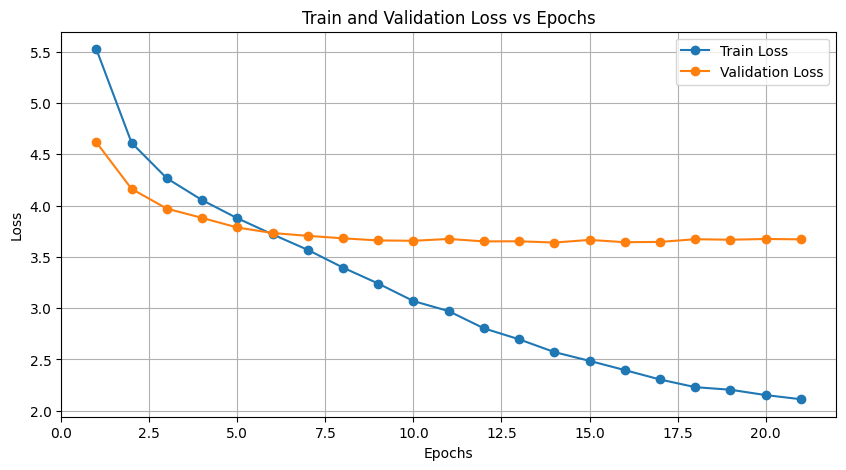

In [21]:
plot_losses(train_losses, val_losses)

In [22]:
eval_multi_metrics

{'eval_loss': 3.670182943344116,
 'eval_wups': 0.3049965332572184,
 'eval_acc': 0.2533051295610788,
 'eval_f1': 0.03488003492108711,
 'eval_runtime': 30.4738,
 'eval_samples_per_second': 186.16,
 'eval_steps_per_second': 5.841,
 'epoch': 19.906103286384976}

In [23]:
model = MultimodalVQAModel()
model.to(device)

MultimodalVQAModel(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [24]:

random_sample_indices = random.sample(range(len(dataset["test"])), k=10)

sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [25]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [27]:
# Get predictions from the model output
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions

array([172, 168, 172, 172, 172, 172, 523, 172, 172, 172])

Sample Predictions

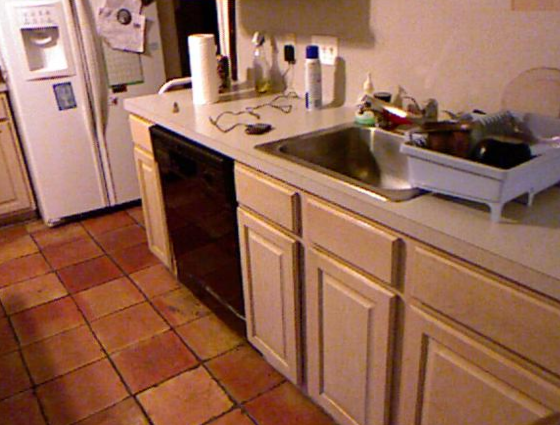

Question:	 what is on the left side of the container
Answer:		 bottle_of_hand_wash_liquid (Label: 64)
Predicted Answer:	 cat_cage
Similarity: 0.3308512164313753






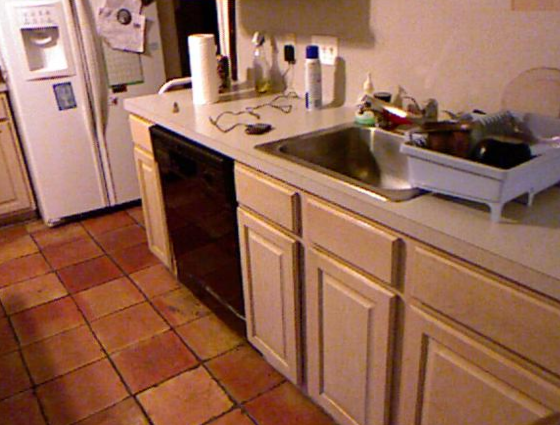

Question:	 what is on the right side of the tap
Answer:		 kitchen_utensils (Label: 301)
Predicted Answer:	 display_case
Similarity: 0.1380952380952381






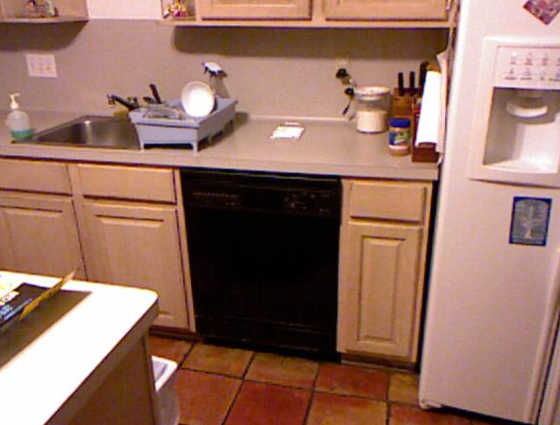

Question:	 what is on the right side of the cellphone charger
Answer:		 plastic_box (Label: 393)
Predicted Answer:	 stove_burner
Similarity: 0.4317226890756303






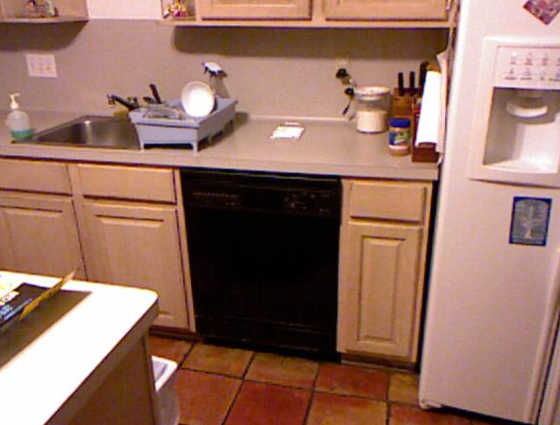

Question:	 what is on the right side of the plastic box
Answer:		 knife_rack, knife (Label: 303)
Predicted Answer:	 air_vent
Similarity: 0.38322440087145976






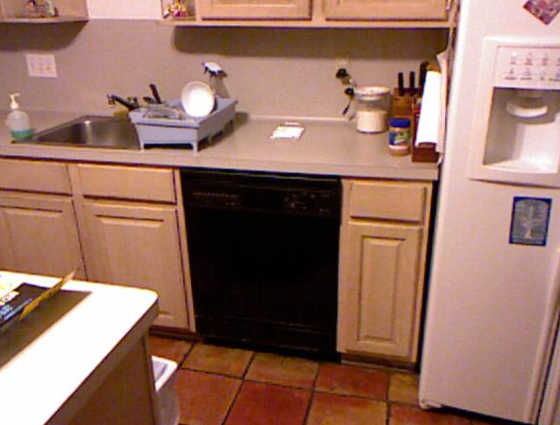

Question:	 what is behind the kitchen utensils
Answer:		 bottle_of_liquid (Label: 65)
Predicted Answer:	 toilet_brush
Similarity: 0.3158119658119658




In [28]:
from nltk.corpus import wordnet

def similarity(a, b):
    # Split words if it is a list and remove extra spaces
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]

    # Split words if connected by underscore _
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0

    # Calculate score and take average
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0

# Show predictions for a range of examples
for i in range(2000, 2005):
    print("\n=========================================================\n")
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[preds[i - 2000]]
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")